In [20]:
# first change the directory over to ssbd release
import os 
import xml.etree.ElementTree as ET

# The first step is preprocessing. We use the [SSBD Dataset](https://rolandgoecke.net/research/datasets/ssbd/) in order to get the data for hand flapping and spinning. 

## The dataset does contain 75 URLs (although we'll ignore all headbanging videos) to youtube videos. All the data is nicely stored in XML files that I will read to get the youtube videos and also the time stamps of when the beheavior (hand flapping or spinning) occurs. Then I will use pytube to download the youtube videos to .mp4 and moviepy to cut the .mp4 videos into just the areas of interest. 

In [21]:
# next step would be to get the hand flapping and spinning data 

tree = ET.parse("ssbd-release/Annotations/v_ArmFlapping_07.xml")
root = tree.getroot()
for child in root:
    # for each child in the root 
    if child.tag == "url":
        print(child.text)
    if child.tag == "behaviours":
        for behavior in child: # go through each reported behavior 
            for tag in behavior: # tag is just the attribute of the behavior 
                if tag.tag == "time":
                    print(tag.text)
                if tag.tag == "intensity":
                    print(tag.text)
                if tag.tag == "category":
                    print(tag.text)

http://www.youtube.com/watch?v=T9rbit_oiJA
0004:0010
armflapping
high
0015:0020
armflapping
high


In [22]:
def convert_to_second(time : str) -> int:
    # this will take in a time like "0125" or 1:25 and make it 85 (60 + 25)
    overall_seconds = 0 
    for i, time_char in enumerate(reversed(time)):
        if i == 0:
            overall_seconds += int(time_char)
        if i == 1:
            overall_seconds += int(time_char) * 10
        if i == 2:
            overall_seconds += int(time_char) * 60 
        if i == 3:
            overall_seconds += int(time_char) * 600 
    return overall_seconds 

assert convert_to_second('2345') == 23 * 60 + 45  

In [23]:
from collections import defaultdict
URLS_TO_DOWNLOAD = set() # contains all youtube videos to download 
links_to_times = {} # data will be stored here like {link : {'category' : [(start, end)], 'another cat' : [(start, end)]}

for i, file_name in enumerate(os.listdir('ssbd-release/Annotations/')):
    # parse this file 
    tree = ET.parse('ssbd-release/Annotations/' + file_name)
    root = tree.getroot() 
    
    # everything we need to store
    URL = ""
    
    for child in root:
        
        if child.tag == "url":
            URL = child.text # store URL
            URLS_TO_DOWNLOAD.add(URL)
            links_to_times[URL] = defaultdict(list) 
        
        if child.tag == "behaviours": # this child has the list of behaviors 
            for reported_behavior in child: 
                for info in reported_behavior:
                    # gather the start time, end time, and category for this youtube link 
                    if info.tag == "time":
                        # the time will be start:end 
                        times = str(info.text) # contains the string 
                        if times.count(":"): 
                            divider_index = times.index(":")
                        elif times.count("-"):
                            divider_index = times.index("-")
                        else:
                            break # invalid then 
                        START_TIME, END_TIME = convert_to_second(times[:divider_index]), convert_to_second(times[divider_index + 1:])
                        
                    if info.tag == "category":
                        # this is the label 
                        LABEL = info.text 
                
                # create an entry for this reported behavior 
                links_to_times[URL][LABEL].append((START_TIME, END_TIME))

In [24]:
# pickle this just incase 
import pickle 
with open("links_to_times.pkl", 'wb') as f:
    pickle.dump(links_to_times, f)

In [31]:
import cv2
import numpy as np
from moviepy.video.io.VideoFileClip import VideoFileClip
from pytube import YouTube # used to download the videos
FPS = 30 
for i, (url, category_times) in enumerate(links_to_times.items()): 
    print(f"staring the {i+1}th file")
    # download the video 
    y = YouTube(url)
    try: 
        y.streams.get_highest_resolution().download() 
    except Exception as e:
        print(f"annoying url: {url}")
        continue 
    for category, times in category_times.items(): 
        folder_path = "behavior_data/" + category + "/"
        
        for start_time, end_time in times:
            try:
                input_file = y.streams.get_highest_resolution().default_filename
                output_file = folder_path + f"{i}.mp4"
                print(os.listdir(folder_path))
                if f"{i}.mp4" not in os.listdir(folder_path):
                    print("adding file")
                    with VideoFileClip(input_file) as video:
                        new = video.subclip(start_time, end_time)
                        new.write_videofile(output_file, audio_codec='aac')
            except Exception as e:
                print(f"failed on {i}")
    os.remove(y.streams.get_highest_resolution().default_filename)

staring the 1th file
['40.mp4', '42.mp4', '43.mp4', '47.mp4', '.DS_Store', '0.mp4', '46.mp4', '44.mp4', '36.mp4', '37.mp4', '35.mp4', '34.mp4', '30.mp4', '31.mp4', '25.mp4', '33.mp4', '27.mp4', '26.mp4', '29.mp4', '38.mp4', '48.mp4']
staring the 2th file


chunk:   0%|          | 0/133 [00:00<?, ?it/s, now=None]

[]
adding file
Moviepy - Building video behavior_data/headbanging/1.mp4.
MoviePy - Writing audio in 1TEMP_MPY_wvf_snd.mp4



t:  39%|███▉      | 70/180 [00:00<00:00, 692.06it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/1.mp4




t:  34%|███▍      | 109/320 [17:25<33:44,  9.59s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/1.mp4
['1.mp4']
['1.mp4']
staring the 3th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 4th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 5th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4',

t:   0%|          | 0/300 [00:00<?, ?it/s, now=None]

Moviepy - Building video behavior_data/headbanging/6.mp4.
MoviePy - Writing audio in 6TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/6.mp4




t:  34%|███▍      | 109/320 [17:50<34:31,  9.82s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/6.mp4
['6.mp4', '1.mp4']
['6.mp4', '1.mp4']
staring the 8th file
annoying url: http://www.youtube.com/watch?v=WcsZ9eMQ5Zs
staring the 9th file


chunk:   0%|          | 0/111 [00:00<?, ?it/s, now=None]

['6.mp4', '1.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/8.mp4.
MoviePy - Writing audio in 8TEMP_MPY_wvf_snd.mp4



t:  46%|████▌     | 68/149 [00:00<00:00, 674.43it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/8.mp4




t:  34%|███▍      | 109/320 [17:52<34:36,  9.84s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/8.mp4
staring the 10th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 11th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4'

t:  34%|███▍      | 109/320 [20:23<39:28, 11.22s/it, now=None]

['6.mp4', '1.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/13.mp4.
MoviePy - Writing audio in 13TEMP_MPY_wvf_snd.mp4



t:  20%|█▉        | 57/286 [00:00<00:00, 527.18it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/13.mp4




t:  34%|███▍      | 109/320 [20:24<39:30, 11.23s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/13.mp4
staring the 15th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 16th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4

t:  34%|███▍      | 109/320 [20:37<39:55, 11.35s/it, now=None]

['6.mp4', '1.mp4', '13.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/19.mp4.
MoviePy - Writing audio in 19TEMP_MPY_wvf_snd.mp4



t:  20%|██        | 61/300 [00:00<00:00, 605.88it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/19.mp4




t:  34%|███▍      | 109/320 [20:38<39:57, 11.36s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/19.mp4
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 21th file
annoying url: http://www.youtube.com/watch?v=pz1nIbRWb2M
staring the 22th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', 

t:   0%|          | 0/121 [00:00<?, ?it/s, now=None]

Moviepy - Building video behavior_data/headbanging/21.mp4.
MoviePy - Writing audio in 21TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/21.mp4




t:  34%|███▍      | 109/320 [20:41<40:03, 11.39s/it, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/21.mp4
staring the 23th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 24th file


chunk:   0%|          | 0/309 [00:00<?, ?it/s, now=None]

['6.mp4', '1.mp4', '21.mp4', '19.mp4', '13.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/23.mp4.
MoviePy - Writing audio in 23TEMP_MPY_wvf_snd.mp4



t:  25%|██▌       | 71/280 [00:00<00:00, 707.85it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/23.mp4




t:  34%|███▍      | 109/320 [20:47<40:14, 11.44s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/23.mp4
staring the 25th file


chunk:   0%|          | 0/155 [00:00<?, ?it/s, now=None]

['6.mp4', '1.mp4', '23.mp4', '21.mp4', '19.mp4', '13.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/24.mp4.
MoviePy - Writing audio in 24TEMP_MPY_wvf_snd.mp4



t:  55%|█████▍    | 115/210 [00:00<00:00, 1149.54it/s, now=None]
                                                                

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/24.mp4



t:  34%|███▍      | 109/320 [20:49<40:18, 11.46s/it, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/24.mp4
staring the 26th file
['40.mp4', '42.mp4', '43.mp4', '47.mp4', '.DS_Store', '0.mp4', '46.mp4', '44.mp4', '36.mp4', '37.mp4', '35.mp4', '34.mp4', '30.mp4', '31.mp4', '25.mp4', '33.mp4', '27.mp4', '26.mp4', '29.mp4', '38.mp4', '48.mp4']
staring the 27th file
['40.mp4', '42.mp4', '43.mp4', '47.mp4', '.DS_Store', '0.mp4', '46.mp4', '44.mp4', '36.mp4', '37.mp4', '35.mp4', '34.mp4', '30.mp4', '31.mp4', '25.mp4', '33.mp4', '27.mp4', '26.mp4', '29.mp4', '38.mp4', '48.mp4']
staring the 28th file
['40.mp4', '42.mp4', '43.mp4', '47.mp4', '.DS_Store', '0.mp4', '46.mp4', '44.mp4', '36.mp4', '37.mp4', '35.mp4', '34.mp4', '30.mp4', '31.mp4', '25.mp4', '33.mp4', '27.mp4', '26.mp4', '29.mp4', '38.mp4', '48.mp4']
['40.mp4', '42.mp4', '43.mp4', '47.mp4', '.DS_Store', '0.mp4', '46.mp4', '44.mp4', '36.mp4', '37.mp4', '35.mp4', '34.mp4', '30.mp4', '31.mp4', '25.mp4', '33.mp4', '27.mp4', '26.mp4', '29.mp4', '38.mp4', '48.mp4']
['40.mp4',

chunk:   0%|          | 0/67 [00:00<?, ?it/s, now=None]

['6.mp4', '1.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/49.mp4.
MoviePy - Writing audio in 49TEMP_MPY_wvf_snd.mp4



t:  34%|███▍      | 109/320 [22:28<43:29, 12.37s/it, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/49.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/49.mp4
staring the 51th file


chunk:   0%|          | 0/486 [00:00<?, ?it/s, now=None]

['6.mp4', '1.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/50.mp4.
MoviePy - Writing audio in 50TEMP_MPY_wvf_snd.mp4



t:  12%|█▏        | 73/610 [00:00<00:00, 722.11it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/50.mp4




t:  34%|███▍      | 109/320 [22:31<43:36, 12.40s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/50.mp4
staring the 52th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 53th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 54th file


t:  34%|███▍      | 109/320 [22:40<43:53, 12.48s/it, now=None]

['6.mp4', '1.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/53.mp4.
MoviePy - Writing audio in 53TEMP_MPY_wvf_snd.mp4



t:   7%|▋         | 68/1020 [00:00<00:01, 675.63it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/53.mp4




t:  34%|███▍      | 109/320 [22:42<43:57, 12.50s/it, now=None]  

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/53.mp4
['6.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 55th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
staring the 56th file


t:  34%|███▍      | 109/320 [23:14<45:00, 12.80s/it, now=None]

['6.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/55.mp4.
MoviePy - Writing audio in 55TEMP_MPY_wvf_snd.mp4



t:  17%|█▋        | 130/780 [00:00<00:00, 1296.20it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/55.mp4




t:  34%|███▍      | 109/320 [23:15<45:02, 12.81s/it, now=None]  

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/55.mp4
staring the 57th file


t:  34%|███▍      | 109/320 [23:17<45:05, 12.82s/it, now=None]

['55.mp4', '6.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/56.mp4.
MoviePy - Writing audio in 56TEMP_MPY_wvf_snd.mp4



t:  57%|█████▋    | 120/210 [00:00<00:00, 1199.20it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/56.mp4




t:  34%|███▍      | 109/320 [23:17<45:05, 12.82s/it, now=None]  

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/56.mp4
staring the 58th file
['55.mp4', '6.mp4', '56.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
adding file


t:   0%|          | 0/150 [00:00<?, ?it/s, now=None]

Moviepy - Building video behavior_data/headbanging/57.mp4.
MoviePy - Writing audio in 57TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/57.mp4




t:  34%|███▍      | 109/320 [23:20<45:10, 12.85s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/57.mp4
['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
staring the 59th file


chunk:   0%|          | 0/177 [00:00<?, ?it/s, now=None]

['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/58.mp4.
MoviePy - Writing audio in 58TEMP_MPY_wvf_snd.mp4



t:  34%|███▍      | 109/320 [23:22<45:15, 12.87s/it, now=None]  

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/58.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/58.mp4
staring the 60th file


chunk:   0%|          | 0/1235 [00:00<?, ?it/s, now=None]

['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4', '58.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/59.mp4.
MoviePy - Writing audio in 59TEMP_MPY_wvf_snd.mp4



t:   4%|▍         | 68/1680 [00:00<00:02, 678.36it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/59.mp4




t:  34%|███▍      | 109/320 [23:29<45:28, 12.93s/it, now=None]   

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/59.mp4
staring the 61th file
['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '49.mp4', '8.mp4', '59.mp4', '58.mp4']
adding file


t:  34%|███▍      | 109/320 [23:32<45:34, 12.96s/it, now=None]      


Moviepy - Building video behavior_data/headbanging/60.mp4.
MoviePy - Writing audio in 60TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/60.mp4



t:  34%|███▍      | 109/320 [23:36<45:42, 13.00s/it, now=None]

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/60.mp4
staring the 62th file


t:  34%|███▍      | 109/320 [23:39<45:48, 13.03s/it, now=None]

['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '60.mp4', '49.mp4', '8.mp4', '59.mp4', '58.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/61.mp4.
MoviePy - Writing audio in 61TEMP_MPY_wvf_snd.mp4



t:  34%|███▍      | 109/320 [23:40<45:49, 13.03s/it, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/61.mp4

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/61.mp4
staring the 63th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.m

t:   0%|          | 0/270 [00:00<?, ?it/s, now=None]

Moviepy - Building video behavior_data/headbanging/64.mp4.
MoviePy - Writing audio in 64TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/64.mp4




t:  34%|███▍      | 109/320 [23:45<45:59, 13.08s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/64.mp4
staring the 66th file


chunk:   0%|          | 0/221 [00:00<?, ?it/s, now=None]

['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '60.mp4', '49.mp4', '61.mp4', '8.mp4', '59.mp4', '64.mp4', '58.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/65.mp4.
MoviePy - Writing audio in 65TEMP_MPY_wvf_snd.mp4



t:  45%|████▍     | 134/300 [00:00<00:00, 1337.15it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/65.mp4




t:  34%|███▍      | 109/320 [23:47<46:03, 13.10s/it, now=None]  

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/65.mp4
staring the 67th file
['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '60.mp4', '49.mp4', '61.mp4', '8.mp4', '59.mp4', '65.mp4', '64.mp4', '58.mp4']
adding file


t:   0%|          | 0/420 [00:00<?, ?it/s, now=None]

Moviepy - Building video behavior_data/headbanging/66.mp4.
MoviePy - Writing audio in 66TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/66.mp4




t:  34%|███▍      | 109/320 [23:50<46:09, 13.13s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/66.mp4
['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '60.mp4', '49.mp4', '61.mp4', '8.mp4', '66.mp4', '59.mp4', '65.mp4', '64.mp4', '58.mp4']
staring the 68th file


['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '60.mp4', '49.mp4', '61.mp4', '8.mp4', '66.mp4', '59.mp4', '65.mp4', '64.mp4', '58.mp4']
adding file


t:   0%|          | 0/180 [00:00<?, ?it/s, now=None]

Moviepy - Building video behavior_data/headbanging/67.mp4.
MoviePy - Writing audio in 67TEMP_MPY_wvf_snd.mp4
MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/67.mp4




t:  34%|███▍      | 109/320 [23:53<46:14, 13.15s/it, now=None] 

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/67.mp4
staring the 69th file
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4', '10.mp4', '62.mp4', '9.mp4', '71.mp4', '70.mp4']
['69.mp4', '68.mp4', '54.mp4', '4.mp4', '5.mp4', '53.mp4', '.DS_Store', '52.mp4', '2.mp4', '51.mp4', '3.mp4', '22.mp4', '21.mp4', '19.mp4', '17.mp4', '16.mp4', '14.mp4', '15.mp4', '11.mp4',

chunk:   0%|          | 0/309 [00:00<?, ?it/s, now=None]

['55.mp4', '6.mp4', '56.mp4', '57.mp4', '1.mp4', '53.mp4', '50.mp4', '23.mp4', '21.mp4', '24.mp4', '19.mp4', '13.mp4', '60.mp4', '49.mp4', '61.mp4', '8.mp4', '66.mp4', '67.mp4', '59.mp4', '65.mp4', '64.mp4', '58.mp4']
adding file
Moviepy - Building video behavior_data/headbanging/73.mp4.
MoviePy - Writing audio in 73TEMP_MPY_wvf_snd.mp4



t:  31%|███       | 129/420 [00:00<00:00, 1284.38it/s, now=None]

MoviePy - Done.
Moviepy - Writing video behavior_data/headbanging/73.mp4




t:  34%|███▍      | 109/320 [24:05<46:38, 13.26s/it, now=None]  

Moviepy - Done !
Moviepy - video ready behavior_data/headbanging/73.mp4


# Directory Structure  

## We have one folder inside of this AnishMachineLearning folder called "behavior_data" that has the "armflapping" and "spinning" folders. There all of the sliced .mp4 files with the behavior of interest are located. 

### We will process headbanging videos even if we are not going to use it because we still want it as a negative case for training the arm flapping & spinning. 

In [12]:
# for spinning it is just the hand positions that matter right?

import cv2
import mediapipe as mp 
import numpy as np
mp_hands = mp.solutions.hands


cap = cv2.VideoCapture("/Users/anish/Documents/Machine Learning Env/AnishMachineLearning/behavior_data/spinning/37.mp4")
#cap = cv2.VideoCapture(0)
# Initiate holistic model

#capcv2.VideoCapture(0)

hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)

while cap.isOpened():
    ret, image = cap.read() 
    if not ret:break 

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False 
    results = hands.process(image)

    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    
    height, width, _ = image.shape

    white_image = np.zeros_like(image)
    white_image.fill(255.0)
    
    #check for hand results 
    if results.multi_hand_landmarks:
        for hand_landmark in results.multi_hand_landmarks:
            for i in range(0, 21):
                landmark = hand_landmark.landmark[i]
                x = int(landmark.x * width)
                y = int(landmark.y * height)
                cv2.circle(white_image, (x, y), 5, (100, 100, 0), -1)

    cv2.imshow("", white_image)

    if cv2.waitKey(1) == ord("q"):
        break 

cap.release() 
cv2.destroyAllWindows()

In [5]:
list(range(21))

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# We can try using the y values for each of the hand flapping videos and graph them to see if there is a noticeable difference of the y-values (we'll use the mean of all y-values for all 21 hand landmarks and then graph them).

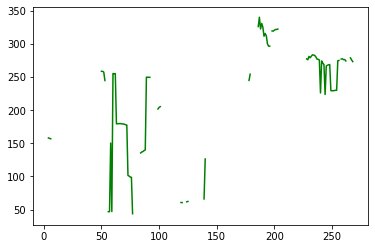

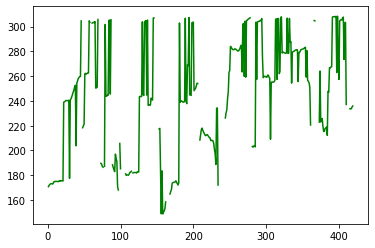

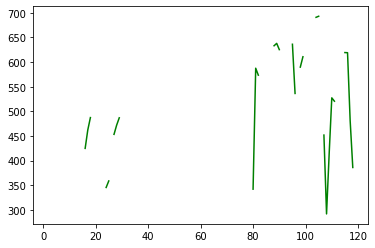

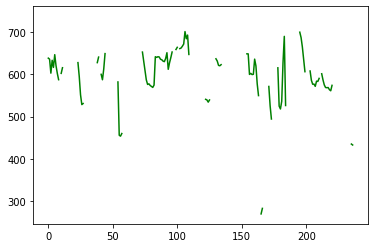

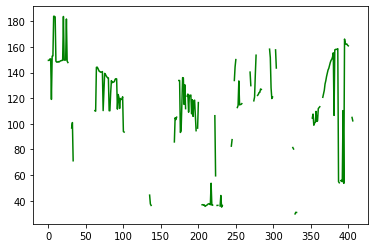

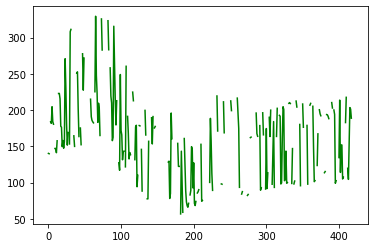

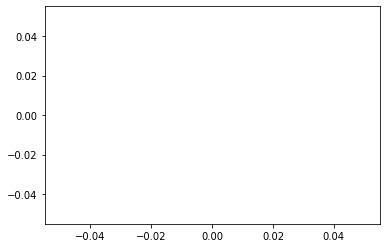

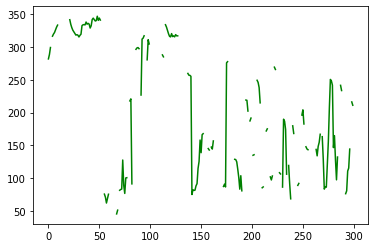

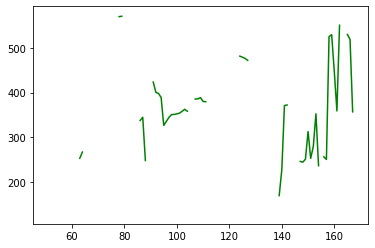

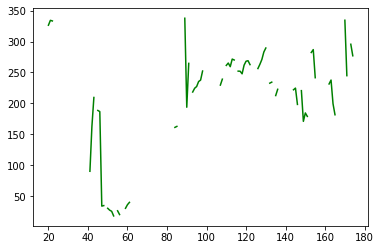

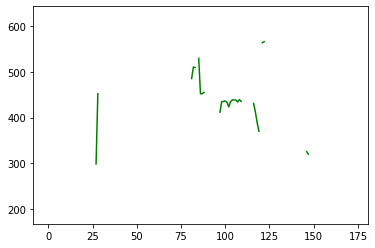

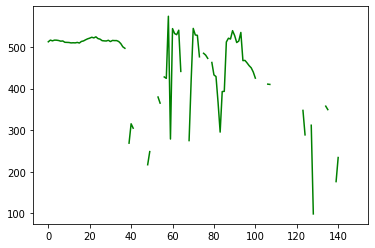

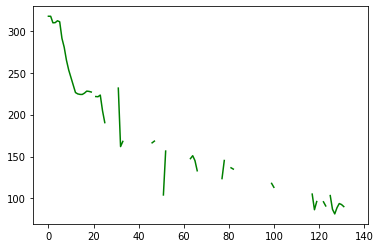

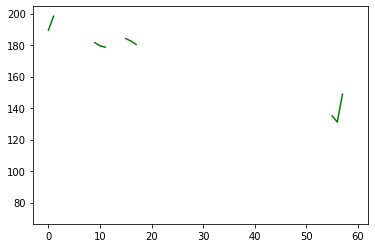

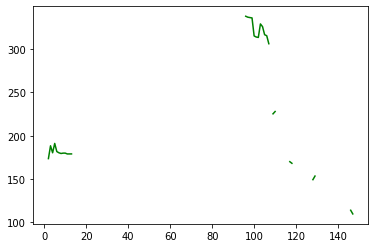

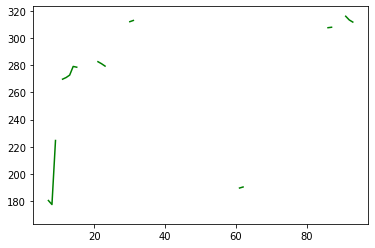

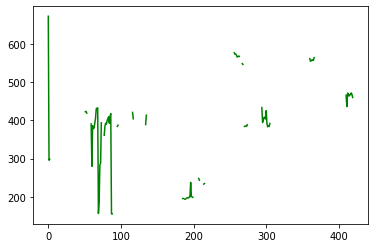

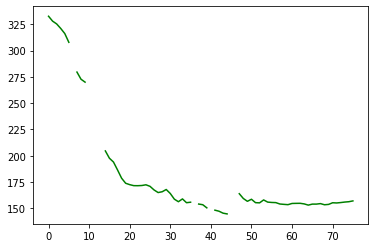

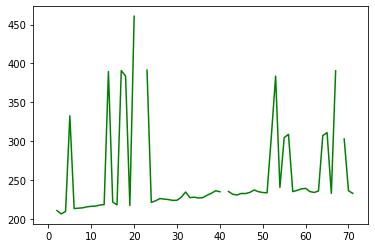

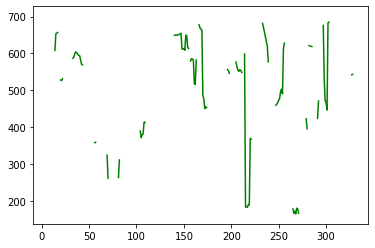

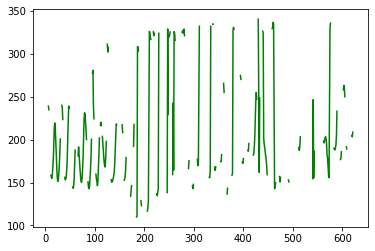

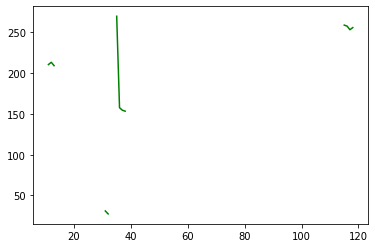

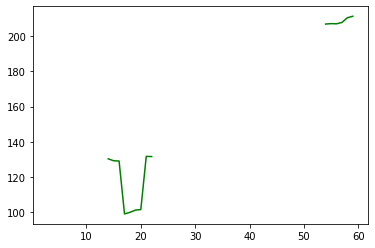

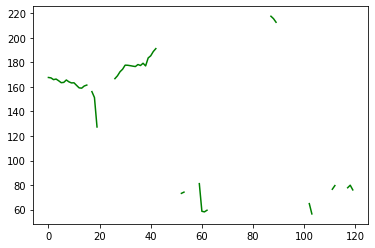

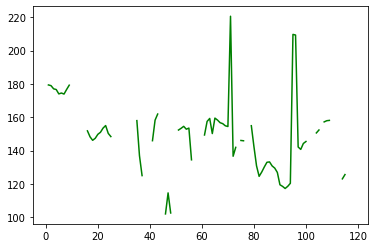

In [16]:
import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/armflapping"):
    video = "behavior_data/armflapping/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

/Users/anish/Library/Python/3.8/lib/python/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/anish/Library/Python/3.8/lib/python/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


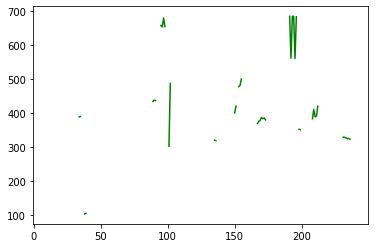

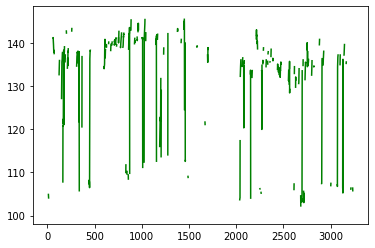

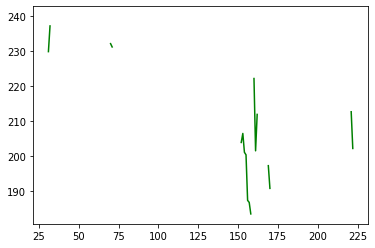

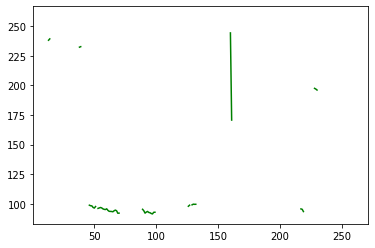

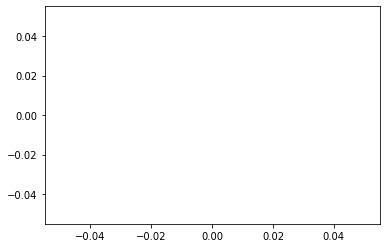

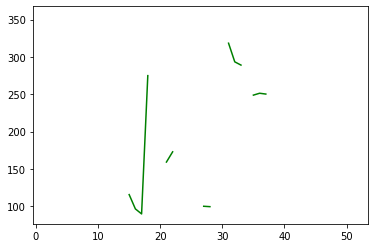

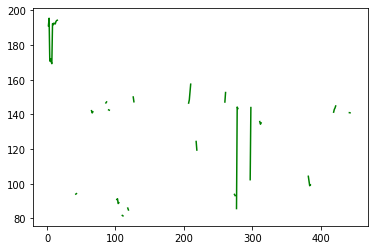

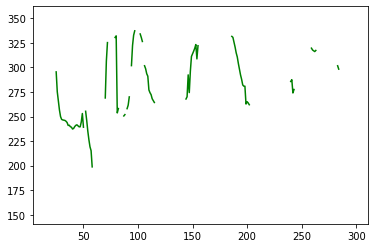

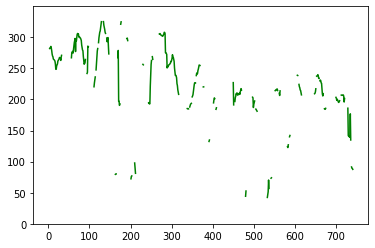

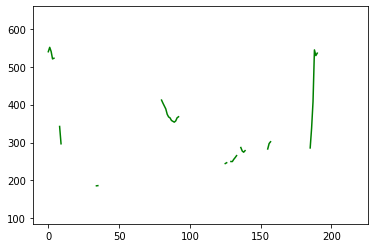

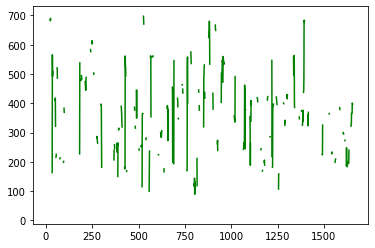

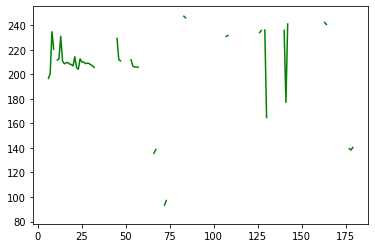

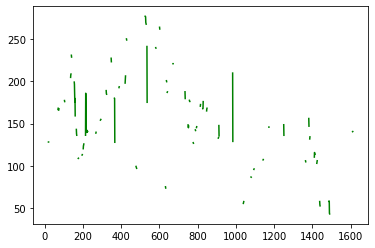

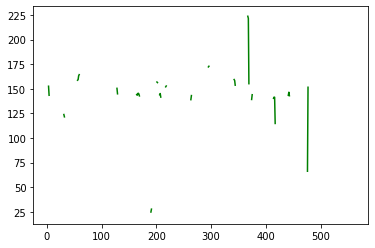

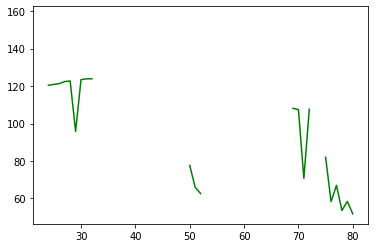

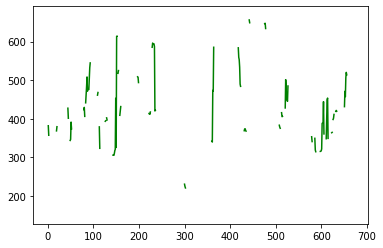

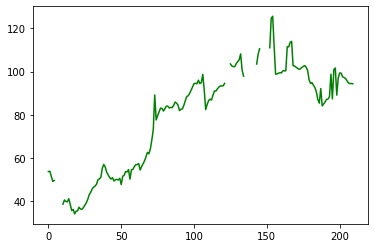

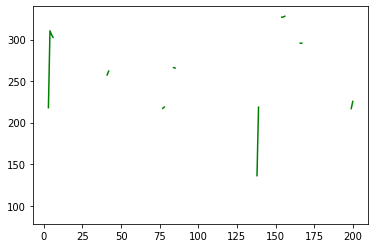

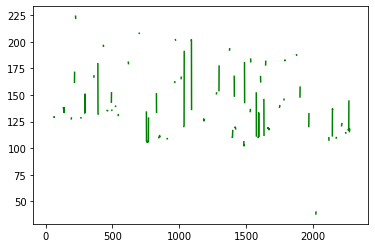

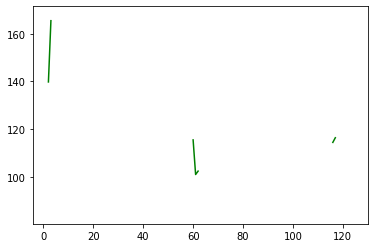

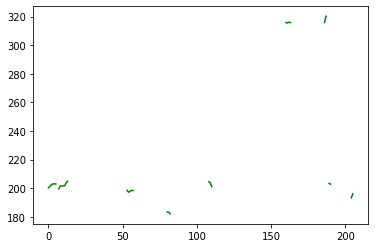

In [17]:
# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/spinning"):
    video = "behavior_data/spinning/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

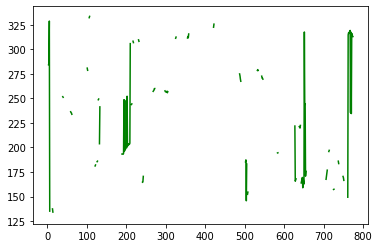

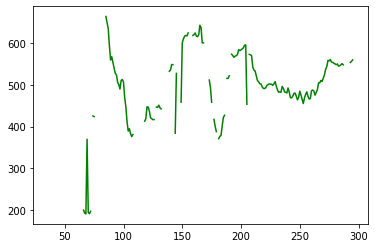

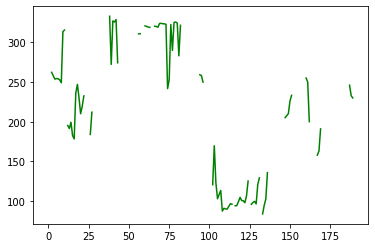

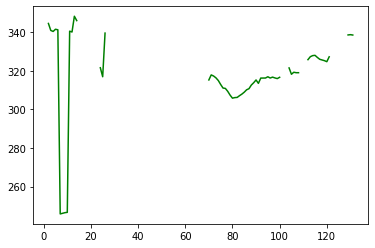

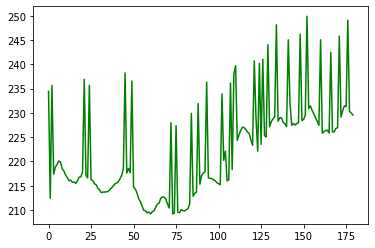

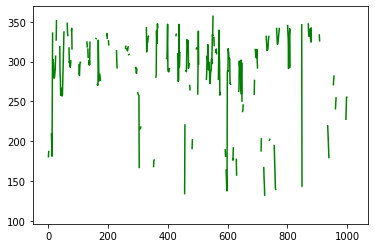

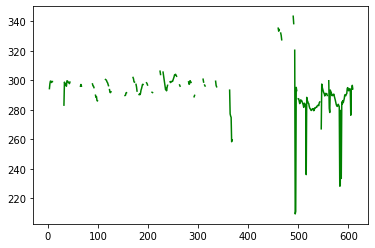

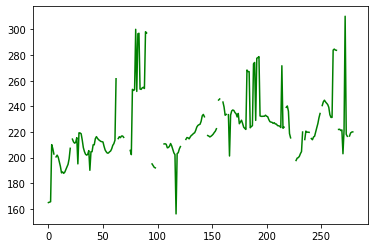

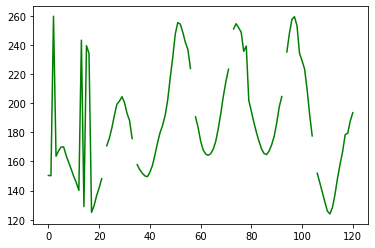

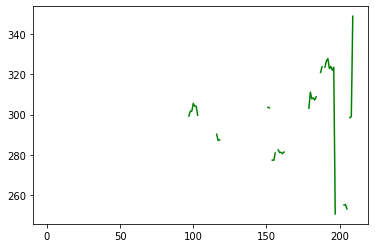

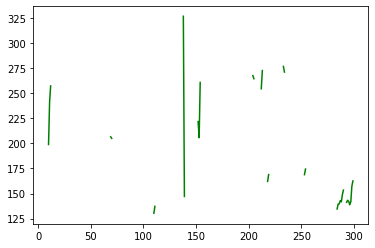

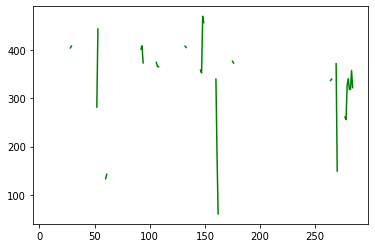

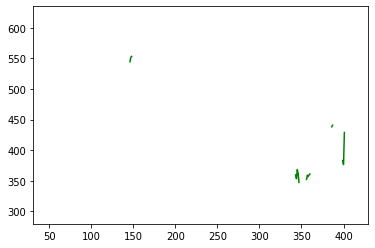

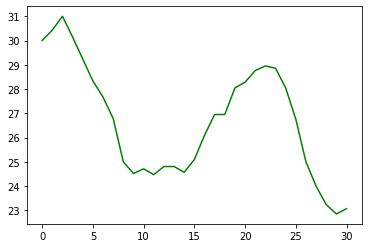

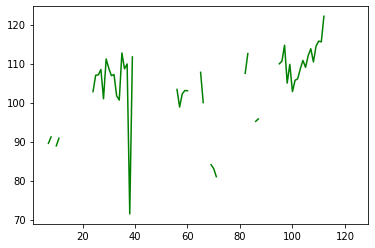

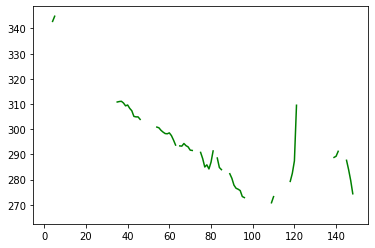

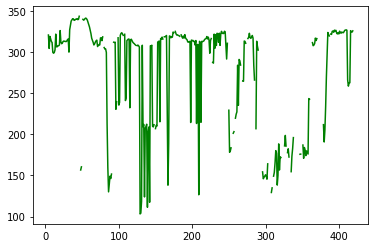

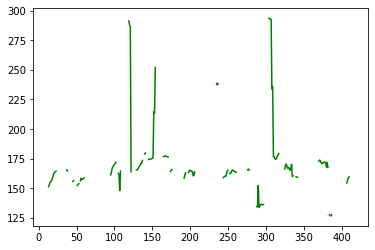

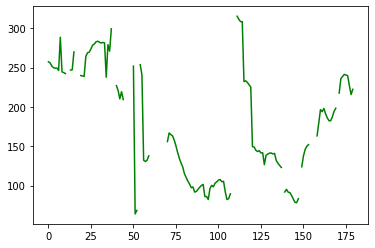

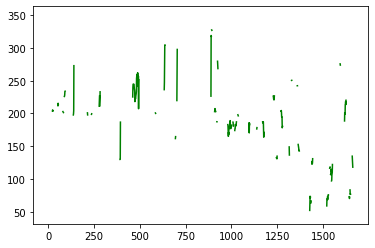

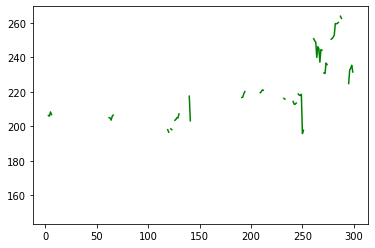

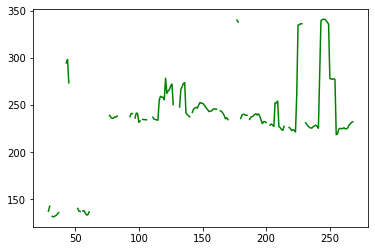

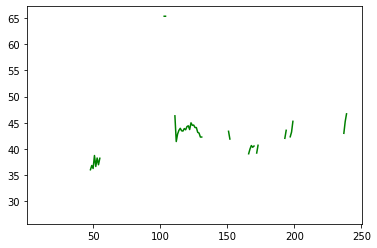

In [32]:
# next for headbanging 

# now for spinning 

import matplotlib.pyplot as plt
import os 

# first all hand flapping videos 
for hand_flap_video in os.listdir("behavior_data/headbanging"):
    video = "behavior_data/headbanging/" + hand_flap_video
    cap = cv2.VideoCapture(video)
    
    hands = mp_hands.Hands(min_detection_confidence = 0.5, min_tracking_confidence = 0.5)
    
    all_YS = [] 
    
    while cap.isOpened():
        ret, image = cap.read() 
        if not ret:break 

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False 
        results = hands.process(image)

        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        height, width, _ = image.shape

        #check for hand results 
        y_s = []
        
        if results.multi_hand_landmarks:
            for hand_landmark in results.multi_hand_landmarks:
                for i in range(0, 21):
                    landmark = hand_landmark.landmark[i]
                    x = int(landmark.x * width)
                    y = int(landmark.y * height)
                    y_s.append(y)
        
        all_YS.append(np.mean(y_s))

    plt.plot(range(len(all_YS)), all_YS, color = "green")
    plt.show()

# to train this LSTM we will need 24 (number of spinning videos) and 24 videos (from both headbanging and spinning) 

In [ ]:
ARMFLAPPING_VIDEOS, ARM_FLAPPING_LABELS = [], [] # all arm flapping labels are 1s 
HEADBANGING_VIDEOS, HEADBANGING_LABELS = [], [] # all headbanging labels are 0s 
SPINNING_VIDEOS, SPINNING_LABELS = [], [] # all spinning labels are 0s 

for video_name in os.listdir('behavior_data/armflapping'):
    FRAMES = [] # all frames for this video 
    cap = cv2.VideoCapture('behavior_data/armflapping/' + video_name)
    
    while True:
        success, frame = cap.read()
        if not success:break 
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        FRAMES.append(frame)
    
    ARMFLAPPING_VIDEOS.append(FRAMES)
    ARM_FLAPPING_LABELS.append(1.0)

for i, video_name in enumerate(os.listdir('behavior_data/headbanging')):
    if i == 13:
        break 
    FRAMES = [] # all frames for this video 
    cap = cv2.VideoCapture('behavior_data/headbanging/' + video_name)
    
    while True:
        success, frame = cap.read()
        if not success:break 
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        FRAMES.append(frame)
    
    HEADBANGING_VIDEOS.append(FRAMES)
    HEADBANGING_LABELS.append(0.0)

for i, video_name in enumerate(os.listdir('behavior_data/spinning')):
    if i == 10:
        break 
    FRAMES = [] # all frames for this video 
    cap = cv2.VideoCapture('behavior_data/spinning/' + video_name)
    
    while True:
        success, frame = cap.read()
        if not success:break 
        
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        FRAMES.append(frame)
    
    SPINNING_VIDEOS.append(FRAMES)
    SPINNING_LABELS.append(0.0)

In [37]:
assert len(HEADBANGING_VIDEOS) == len(HEADBANGING_LABELS)
assert len(ARM_FLAPPING_LABELS) == len(ARMFLAPPING_VIDEOS)
assert len(SPINNING_VIDEOS) == len(SPINNING_LABELS) 

## we can try using the 21-y-value representation to an LSTM 
## or we can explore the mediapipe images